In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout,GRU,BatchNormalization, Reshape,TimeDistributed,RepeatVector, Input
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from IPython.display import clear_output
from math import factorial
from scipy.signal import savgol_filter
from keras.initializers import HeNormal
from keras.regularizers import l2


import time
input_sequence_length = 24
output_sequence_length = 24
n_features = 3
step = 5

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#path = '/content/gdrive/My Drive/data.npy'
path = 'data.npy'

In [3]:
data = np.load(path, allow_pickle=True)
#data = data[:50]
print(data.shape)
data_concat = []
(a,b,c) = data.shape
for i in range(a):
    for j in range(b):
        data_concat.append(data[i][j])
data_concat = pd.DataFrame(data_concat,columns=['bt','et','burner'])
data_concat.dropna(inplace=True)
data_concat.head()
data_concat.describe()


(231, 729, 3)


,bt,et,burner
count,154840.000000,154840.000000,154840.000000
mean,160.814159,204.632900,3.063801
std,39.658877,20.179814,0.728714
min,76.800000,153.900000,1.100000
25%,131.300000,190.600000,2.400000
50%,170.600000,213.600000,3.300000
75%,195.800000,220.900000,3.500000
max,213.400000,235.500000,5.000000


In [4]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        u = y.iloc[i + time_steps:i + time_steps+1]
        ys.append(u)
    return np.array(Xs), np.array(ys)

X = data_concat[['bt', 'et', 'burner']]
y = data_concat[['bt', 'et']]

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

#X = x_scaler.fit_transform(X)
#y = y_scaler.fit_transform(y)

x_scaler.fit(X)
y_scaler.fit(y)

X = []
y = []
for roast in data:
    roast = pd.DataFrame(roast,columns=['bt','et','burner'])
    roast.dropna(inplace=True)
    roast = x_scaler.transform(roast)
    for j in range(roast.shape[0]-input_sequence_length*step):
        X.append(roast[j:j+input_sequence_length*step][::step])
        y.append(roast[j+input_sequence_length*step,:2])
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X_train, y_train = create_dataset(pd.DataFrame(X_train), pd.DataFrame(y_train), input_sequence_length)
#X_test, y_test = create_dataset(pd.DataFrame(X_test), pd.DataFrame(y_test), input_sequence_length)

print(X_train.shape, y_train.shape)
print(X_train[0], y_train[0])
#print(X_train[1], y_train[1])


(127120, 24, 3)
(127120, 2)
(127120, 24, 3)
(127120, 2)
(101696, 24, 3) (101696, 2)
[[0.89458272 0.85171569 0.28205128]
 [0.89897511 0.84926471 0.28205128]
 [0.9033675  0.84926471 0.28205128]
 [0.90775988 0.84926471 0.28205128]
 [0.91215227 0.84926471 0.28205128]
 [0.91581259 0.84926471 0.28205128]
 [0.91947291 0.84926471 0.28205128]
 [0.9238653  0.84926471 0.28205128]
 [0.92679356 0.85171569 0.28205128]
 [0.93045388 0.85416667 0.28205128]
 [0.93338214 0.85661765 0.28205128]
 [0.93704246 0.85784314 0.28205128]
 [0.93923865 0.86151961 0.28205128]
 [0.94289898 0.8627451  0.28205128]
 [0.94582723 0.86397059 0.28205128]
 [0.94802343 0.86764706 0.23076923]
 [0.95168375 0.86642157 0.23076923]
 [0.95387994 0.86397059 0.23076923]
 [0.95607613 0.86029412 0.23076923]
 [0.95827233 0.85906863 0.23076923]
 [0.96120059 0.85784314 0.23076923]
 [0.96266471 0.85661765 0.23076923]
 [0.96486091 0.85661765 0.23076923]
 [0.9670571  0.85661765 0.17948718]] [0.96998536 0.85539216]


In [5]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(input_sequence_length, n_features),
               return_sequences=False,unroll=True))
model.add(Dense(2))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

def scheduler(epoch, lr):
    if epoch < 400 or epoch > 500:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
# define the checkpoint
filepath = "model_checkpoint.keras"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [lrs]
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=1000,
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks=callbacks_list
)

Epoch 1/1000
 329/1589 [=====>........................] - ETA: 53s - loss: 0.0071

KeyboardInterrupt: 

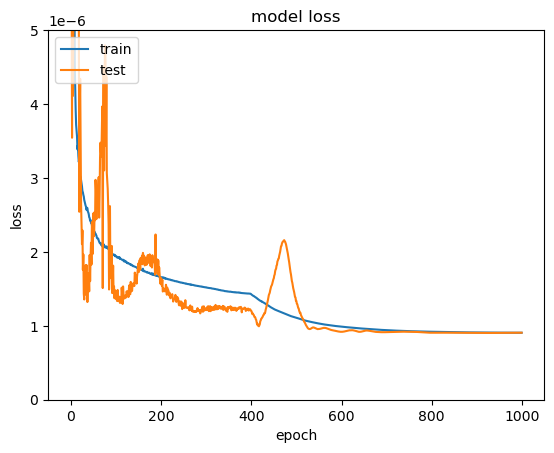

In [11]:
model.save('model.keras')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0,0.000005)
plt.show()

In [35]:
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
#plt.legend()
#plt.show()

test_roast = data[120]
test_roast = pd.DataFrame(test_roast,columns=['bt','et','burner'])
test_roast.dropna(inplace=True)
X_test_roast = x_scaler.transform(test_roast)

print(X_test_roast.shape)
offset = 420
pred_length = 24
current_batch = X_test_roast[offset:offset+input_sequence_length*step][::step]
current_batch = np.expand_dims(current_batch,0)
print(current_batch.shape)
print(current_batch)


test_predictions = []
for i in range(pred_length):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    #print(current_pred)
    # store prediction
    test_predictions.append(current_pred)
    #print(X_test_roast[offset+(input_sequence_length+1+i)*step,2])
    current_pred = np.append(current_pred,X_test_roast[offset+(input_sequence_length+1+i)*step,2])
    #update batch to now include prediction and drop first value
    print(current_pred)
    #print(current_batch)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)



(693, 3)
(1, 24, 3)
[[[0.77525622 0.7745098  0.43589744]
  [0.78038067 0.7745098  0.43589744]
  [0.78696925 0.77696078 0.43589744]
  [0.79136164 0.77818627 0.43589744]
  [0.79648609 0.78186275 0.43589744]
  [0.80161054 0.78553922 0.43589744]
  [0.80746706 0.78921569 0.43589744]
  [0.81259151 0.79411765 0.43589744]
  [0.81771596 0.79779412 0.41025641]
  [0.82284041 0.80147059 0.41025641]
  [0.82796486 0.80269608 0.35897436]
  [0.83308931 0.80269608 0.35897436]
  [0.83821376 0.80147059 0.35897436]
  [0.84260615 0.8002451  0.35897436]
  [0.8477306  0.80147059 0.35897436]
  [0.85212299 0.80147059 0.35897436]
  [0.85724744 0.80392157 0.35897436]
  [0.86237189 0.80637255 0.35897436]
  [0.86749634 0.80882353 0.30769231]
  [0.87188873 0.81004902 0.30769231]
  [0.87701318 0.81004902 0.30769231]
  [0.8806735  0.80882353 0.30769231]
  [0.88506589 0.80882353 0.30769231]
  [0.88945827 0.80759804 0.30769231]]]
1/1 [==============================] - 0s 15ms/step
[0.89360428 0.80755436 0.30769231]
1/1

444


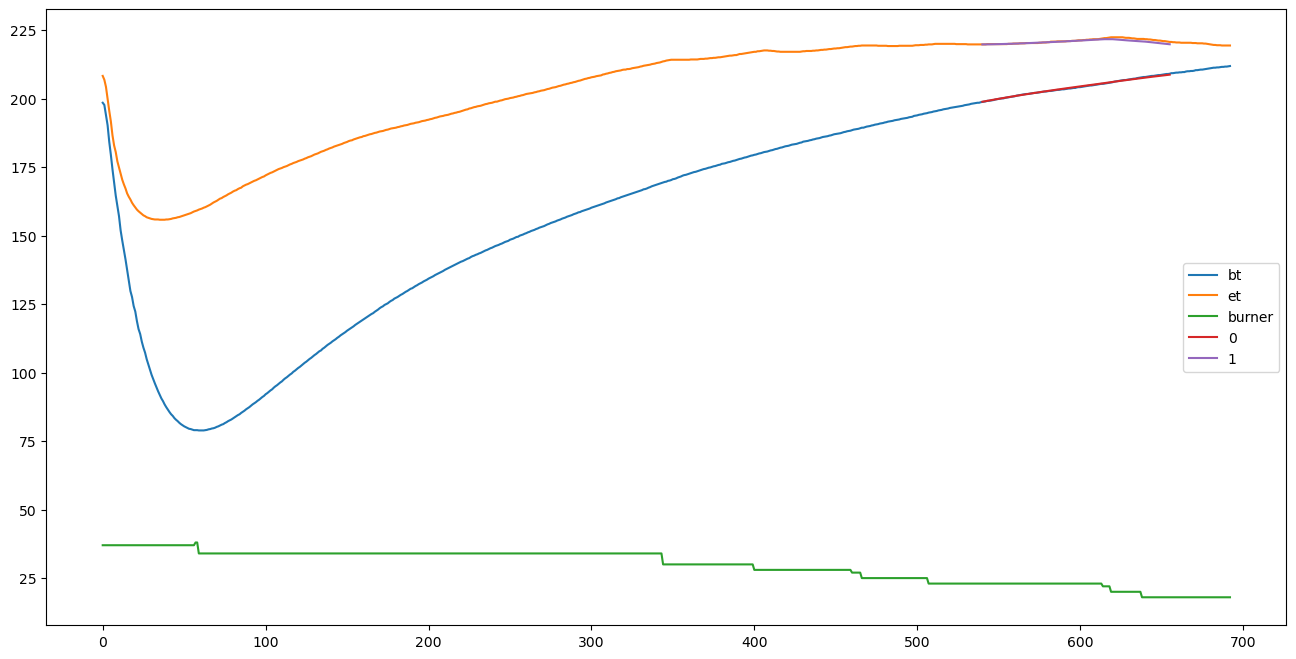

In [36]:
true_test_predictions = y_scaler.inverse_transform(test_predictions)
print(offset+input_sequence_length)
forecast_index = np.arange(offset+input_sequence_length*step,offset+(input_sequence_length+pred_length)*step,step)

test_roast['burner'] = test_roast['burner']*10
forecast_df = pd.DataFrame(data=true_test_predictions,index=forecast_index)
ax = test_roast.plot(figsize=(16,8))
forecast_df.plot(ax=ax)
plt.show()

In [ ]:
test_roast = data[0]
test_roast = pd.DataFrame(test_roast,columns=['bt','et','burner'])
test_roast.dropna(inplace=True)
X_test_roast = x_scaler.transform(test_roast)
offset = 300
current_batch = X_test_roast[offset:offset+input_sequence_length]
current_batch = np.expand_dims(current_batch,0)

y_preds = model.predict(current_batch)[0]

print(y_preds.shape)
true_test_predictions = y_scaler.inverse_transform(y_preds)
print(true_test_predictions.shape)
forecast_index = np.arange(offset+input_sequence_length,output_sequence_length+offset+input_sequence_length,1)

forecast_df = pd.DataFrame(data=true_test_predictions,index=forecast_index)
ax = test_roast.plot(figsize=(16,8))
forecast_df.plot(ax=ax)
plt.show()

220


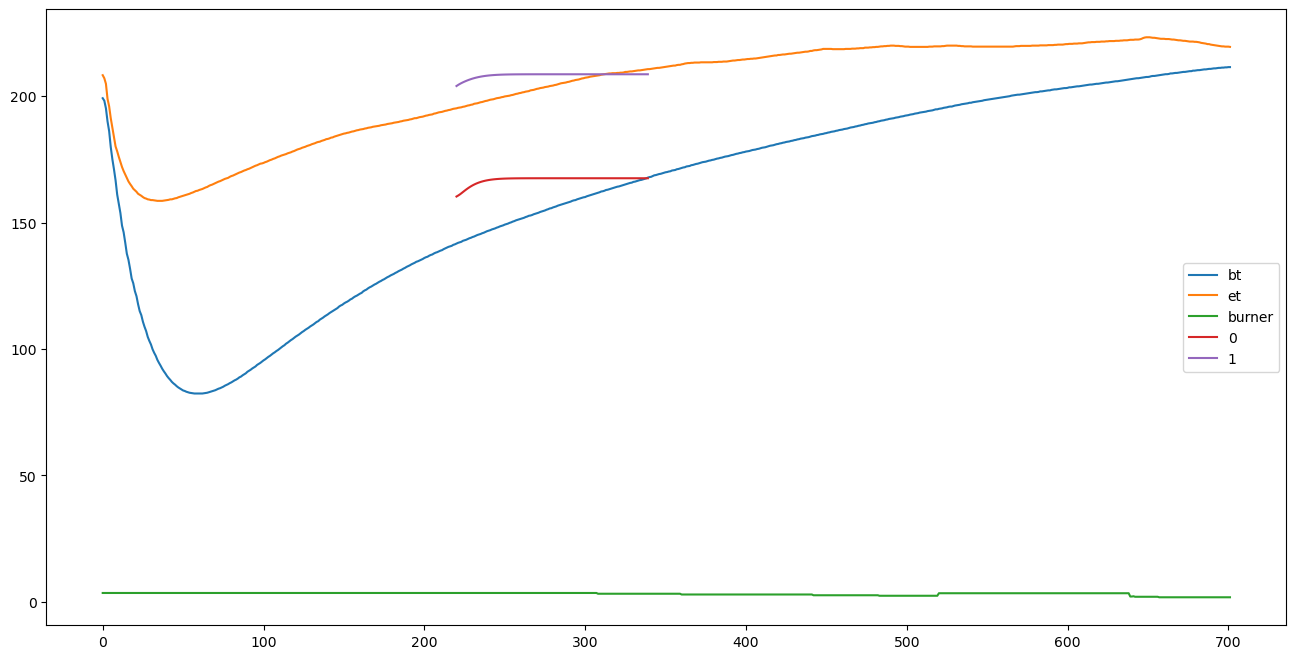